In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName('Predicting the price of an automobile given a set of features')\
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('datasets/imports-85.data')

In [2]:
rawData.toPandas().head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


**Select the required columns**

- We can select the specific features we feel are relevant in our dataset
- fields such as normalized-losses have been dropped
- The numeric fields can be cast as float or numeric type

In [3]:
from pyspark.sql.functions import col

dataset = rawData.select(col('price').cast('float'), 
                         col('make'), 
                         col('num-of-doors'), 
                         col('body-style'), 
                         col('drive-wheels'), 
                         col('wheel-base').cast('float'), 
                         col('curb-weight').cast('float'), 
                         col('num-of-cylinders'), 
                         col('engine-size').cast('float'), 
                         col('horsepower').cast('float'), 
                         col('peak-rpm').cast('float')
                        )

In [4]:
dataset.toPandas().head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,peak-rpm
0,13495.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
1,16500.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
2,16500.0,alfa-romero,two,hatchback,rwd,94.500000,2823.0,six,152.0,154.0,5000.0
3,13950.0,audi,four,sedan,fwd,99.800003,2337.0,four,109.0,102.0,5500.0
4,17450.0,audi,four,sedan,4wd,99.400002,2824.0,five,136.0,115.0,5500.0


**Drop columns with nulls**

Check number of rows in dataset before and after removal of nulls

In [5]:
dataset.count()

205

In [6]:
dataset = dataset.replace('?', None).dropna(how='any')

In [7]:
dataset.count()

197

**Split dataset into training and test sets**

In [8]:
(trainingData, testData) = dataset.randomSplit([0.8, 0.2])

**List the categorrical fields so that we can transform these to encoded values**

In [10]:
categoricalFeatures = ['make',
                      'num-of-doors',
                      'body-style',
                      'drive-wheels',
                      'num-of-cylinders']

**Import and Implement the required transformations**

In [11]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

**Use of handleInvalid in StringIndexer**

If the model comes across a new label which it hasn't seen in the training phase, it is deemed an "invalid" label. There are different ways of handling this:

   - handleInvalid='skip' will remove rows with new labels
   - handleInvalid='error' will cause an error when a new label is encountered
   - handleInvalid='keep' will create a new index if it encounters a new label (available from Spark 2.2 onwards)



In [14]:
indexers = [StringIndexer(
    inputCol=column,
    outputCol=column + '_index',
    handleInvalid='keep') for column in categoricalFeatures]

In [33]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in categoricalFeatures]

**List all the required features from the transformed dataset**

In [15]:
requiredFeatures = ['make_encoded',
                    'num-of-doors_encoded',
                    'body-style_encoded',
                    'drive-wheels_encoded',
                    'wheel-base',
                    'curb-weight',
                    'num-of-cylinders_encoded',
                    'engine-size',
                    'horsepower',
                    'peak-rpm'
                   ]

**Prepare the feature assenbler**

In [17]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='feature')

**Linear Regression**

By setting α properly, elastic net contains both L1 and L2 regularization as special cases.

   - If the elasticNetParam α is set to 1, it is equivalent to a Lasso model
   - If α is set to 0, the trained model reduces to a ridge regression model

regParam is the regularization variable


In [36]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,
                     regParam=1.0,
                     elasticNetParam=0.8,
                     labelCol='price',
                     featuresCol='feature')

**Define our pipeline**

it contains all our transformers plus the model

In [37]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [38]:
model = pipeline.fit(trainingData)
model

PipelineModel_4777ab86d8a53e483d6c

**Extract the model from the pipeline **

   - Our LinearRegression model is not the same as the pipeline model
   - To extract the LinearRegression model, we get it from the last stage of our pipeline model


In [39]:
lrModel = model.stages[-1]

In [40]:
print('Training RMSE = ', lrModel.summary.rootMeanSquaredError)
print('Training R^2 score = ', lrModel.summary.r2)

Training RMSE =  1890.9036700889214
Training R^2 score =  0.9462893887594855


**Check the number of features**

The number will be high as many of our features are one-hot-encoded


In [41]:
lrModel.numFeatures

42

**View the coefficients of each feature**

In [42]:
lrModel.coefficients

DenseVector([-1862.0853, -147.5654, -627.8895, -1632.2868, -1075.4679, 1235.7982, -800.8609, -2027.0478, 6775.5253, -1754.2688, 3048.0231, 1165.535, -1961.4814, 7980.4756, 11202.2909, -1691.6577, -1003.8204, 409.5578, 3231.7473, -520.3083, -8.3288, 8.3288, 183.2939, -493.3597, -824.969, 635.8446, 3200.5736, 175.3144, -402.0917, 608.1862, 117.716, 3.6891, -1091.52, 739.8594, -1101.0612, 2459.2385, 2990.5081, 1992.4019, 484.8071, 32.4693, 40.7924, 0.0271])

**There is a coefficient for each feature**

In [43]:
len(lrModel.coefficients)

42

**Get predictions using our model on the test data**

In [44]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,feature,prediction
0,5499.0,nissan,two,sedan,fwd,94.500000,1889.0,four,97.0,69.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6336.933814
1,5572.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5198.825191
2,6229.0,plymouth,four,hatchback,fwd,93.699997,1967.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5248.052531
3,6338.0,toyota,two,hatchback,fwd,95.699997,2040.0,four,92.0,62.0,...,1.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5670.068652
4,6377.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5198.825191


**The features have been transformed to LibSVM format**

In [46]:
predictionsDF['feature'][0]

SparseVector(42, {3: 1.0, 21: 1.0, 22: 1.0, 27: 1.0, 30: 94.5, 31: 1889.0, 32: 1.0, 39: 97.0, 40: 69.0, 41: 5200.0})

**Use RegressionEvaluator to evaluate the model**

  -  MulticlassClassificationEvaluator is used for classification models
  -  RegressionEvaluator needed to evaluate regression models
  -  metricName can be r2, rmse, mse or mae (mean absolute error)

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

r2 = evaluator.evaluate(predictions)
print('Test R^2 score = ', r2)

Test R^2 score =  0.933472266824869


In [49]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  1923.522906739916


**Compare the actual and predicted values of price**

In [50]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')
).toPandas()

In [51]:
predictionsPandasDF.head()

,price,prediction
0,5499.0,6336.933814
1,5572.0,5198.825191
2,6229.0,5248.052531
3,6338.0,5670.068652
4,6377.0,5198.825191


**Plot a graph of actual and predicted values of price**

Note that our predictions dataset is sorted in ascending order of price


Exception ignored in: <function JavaParams.__del__ at 0x11b6afa60>
Traceback (most recent call last):
  File "/Users/nikolayvaklinov/server/spark-2.3.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'
Exception ignored in: <function JavaParams.__del__ at 0x11b6afa60>
Traceback (most recent call last):
  File "/Users/nikolayvaklinov/server/spark-2.3.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'LinearRegression' object has no attribute '_java_obj'


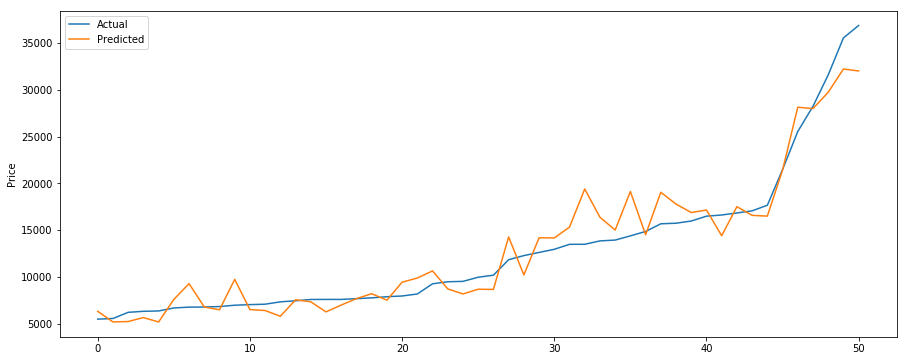

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show()

**Using ParamGrid for hyperparameter tuning**

The parameters we wish to tweak are:

  - maxIter
  - regParam
  - elasticNetParam - whether a lasso or ridge model will be best



In [54]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder().addGrid(
    lr.maxIter, [10,50,100]).addGrid(
    lr.regParam, [0.1, 0.3, 1.0]).addGrid(
    lr.elasticNetParam, [0.0, 1.0]).build()

**Define the RegressionEvaluator used to evaluate the models**

We wish to minimize RMSE


In [56]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

**Define the CrossValidator**

This is used to put all the pieces together

 -   estimator: Can be a standalone estimator or a pipeline with an estimator at the end. We use our pipeline
 -  estimatorParamMaps: We add our paramGrid in order to build models with different combinations of the parameters
 -  evaluator: To evaluate each model, we specify our evaluator



In [57]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

**Train each of our models with the training data**

After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset


In [58]:
model = crossval.fit(trainingData)

**To examine our best model, we extract it from the pipeline**

In [59]:
lrModel = model.bestModel.stages[-1]
lrModel

LinearRegression_447f88b66fefaf240587

#### Get the values of the "best" parameters
Unfortunately, extracting these values is a bit awkward as we need to access the \_java\_obj object 

In [60]:
print('maxIter=', lrModel._java_obj.getMaxIter())
print('elasticNetParam=', lrModel._java_obj.getElasticNetParam())
print('regParam=', lrModel._java_obj.getRegParam())

maxIter= 10
elasticNetParam= 1.0
regParam= 0.1


### Make predictions using our "best" model

In [61]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,feature,prediction
0,5499.0,nissan,two,sedan,fwd,94.500000,1889.0,four,97.0,69.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6161.806888
1,5572.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5066.493907
2,6229.0,plymouth,four,hatchback,fwd,93.699997,1967.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5625.044312
3,6338.0,toyota,two,hatchback,fwd,95.699997,2040.0,four,92.0,62.0,...,1.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5430.995556
4,6377.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5066.493907


### Evaluate the model on it's R-square score and RMSE

In [62]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

rsquare = evaluator.evaluate(predictions)
print("Test R^2 score = %g" % rsquare)

Test R^2 score = 0.929771


In [63]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  1976.310238153916


### Compare actual and predicted values of price

In [64]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')).toPandas()

predictionsPandasDF.head()

,price,prediction
0,5499.0,6161.806888
1,5572.0,5066.493907
2,6229.0,5625.044312
3,6338.0,5430.995556
4,6377.0,5066.493907


### Perform the comparison using a graph

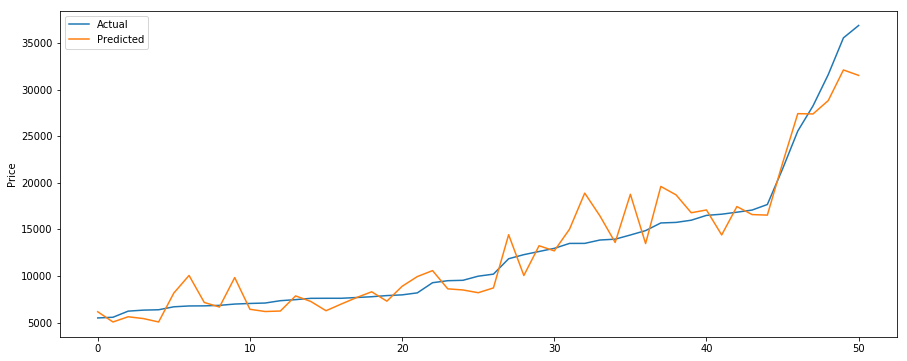

In [65]:
plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show()